In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns


from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


import statsmodels.api as sm

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train =  pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True)
train = train.fillna(np.nan)

# Data pre-processing

In [4]:
#### გავიგოთ რამდენი უჯრაა ცარიელი 
print(train.isnull().sum())



PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [5]:
#### რადგან კაბინის სვეტში 687 ცარიელი უჯრაა 890-დან,ამოვიღოთ ეს სვეტი
train = train.drop(columns = 'Cabin',axis = 1)

In [6]:
#### ამოვიღოთ ასევე ბილეთების და ID-ს სვეტი,რადგან შედეგზე ისინი ვერ იმოქმედებენ
train = train.drop(columns = 'Ticket',axis = 1)
train = train.drop(columns = 'PassengerId',axis = 1)

In [7]:
#### წლოვანების სვეტში 177 ცარიელი უჯრაა 890-დან და მოდი ეს ცარიელი უჯრები არსებულის საშუალოთი წარმოვადგინოთ
train["Age"].fillna(train["Age"].mean(),inplace = True)

In [8]:
#### გვრჩება ორი ცარიელი უჯრა Embarked სვეტში და შევავსოთ არსებულის მოდით
print(train['Embarked'].mode())
train["Embarked"].fillna(train["Embarked"].mode()[0],inplace = True)

0    S
dtype: object


In [9]:
#### არჩერთი ცარიელი უჯრა აღარ გვაქვს
train.isnull().sum()

Survived    418
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          1
Embarked      0
dtype: int64

In [10]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [11]:
#### სქესთა სვეტი წარმოვადგინოთ ბინარული სტილით (dummy variables)
train.replace({'Sex':{'male':0,'female':1}}, inplace=True)

In [12]:
#### ასევე Embarked სვეტიც
train.replace({'Embarked':{'S':0,'C':1,'Q':2}}, inplace=True)

In [13]:
train["SibSp"].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [14]:
#### შემოვიტანოთ დამატებითი პარამეტრი Family size 
train["Family size"] = train["SibSp"] + train["Parch"] + 1
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family size
0,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0,2
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1,2
2,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,0,2
4,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0,1


<AxesSubplot:>

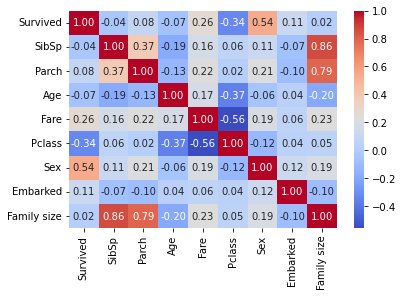

In [15]:
#### კორელაციის მატრიცა რათა დავინახოთ კავშირი ნუმერაციულ პარამეტრებს შორის
sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare","Pclass","Sex","Embarked","Family size"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

#### ვხედავთ რომ გადარჩენილებსა და სქესს შორის მაღალი კორელაცია გვაქვს.
#### განვიხილოთ სხვა პარამამეტრებიც

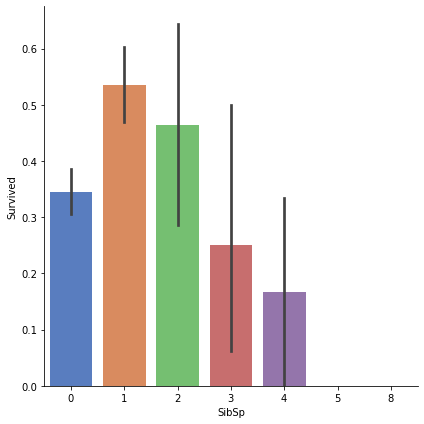

In [16]:
sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", height = 6 ,palette = "muted")

##### 3 და 4 sibsp შემთხვევაში ნაკლებია შანსი გადარჩენი განსხვავებით 0,1, და 2

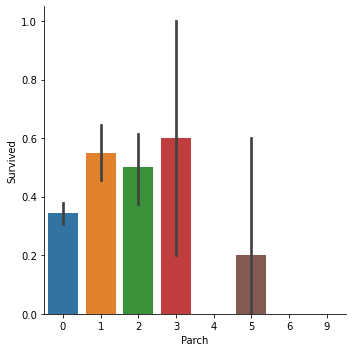

In [17]:
sns.catplot(x="Parch",y="Survived",data=train,kind="bar")

#### რაც პატარაა Parch მით დიდია შანსი გადარჩენის

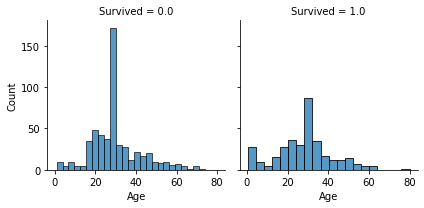

In [18]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot, "Age")

#### ჩვენ ვაჩვენეთ რომ ასაკს და გადარჩენილთა შორის კორელაცია არ იყო (0,07),მაგრამ შეიმჩნევა ის,რომ 20 დან 40 წლამდე ადამიანთა შორის დიდია გადარჩენის შანსი

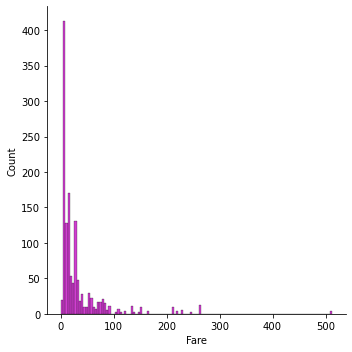

In [19]:
sns.displot(train["Fare"], color="m")

In [20]:
#### ძაან დახრილია,ამიტომ ნორმალიზაცია მოვახდინოთ
train["Fare"] = train["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

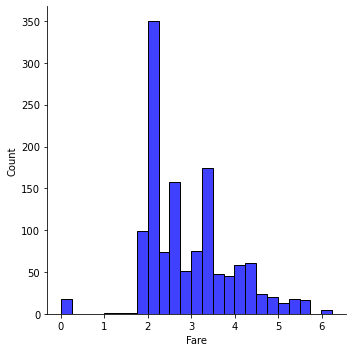

In [21]:
sns.displot(train["Fare"], color="b")

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

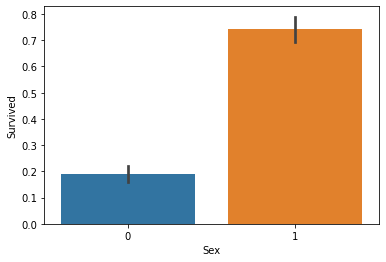

In [22]:
sns.barplot(x="Sex",y="Survived",data=train)

In [23]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
0,0.188908
1,0.742038


#### ქალებს მეტი შანსი აქვთ

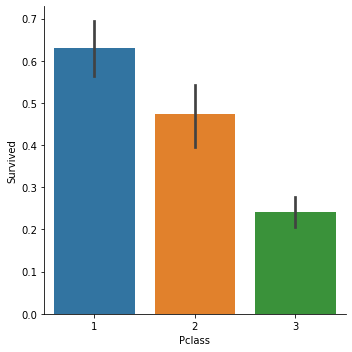

In [24]:
sns.catplot(x="Pclass",y="Survived",data=train,kind="bar")

#### პირველი კლასის მგზავრებს მეტი შანსი აქვთ

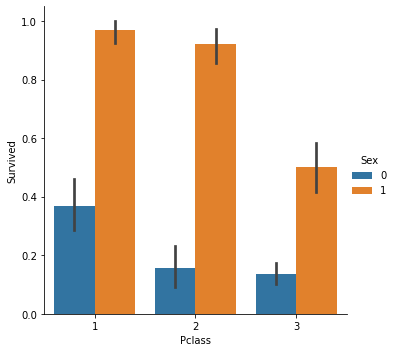

In [25]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar")

#### გამოვყოთ წოდებები სახელებიდან

In [26]:
train["Title"] = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
train["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

<AxesSubplot:xlabel='Title', ylabel='count'>

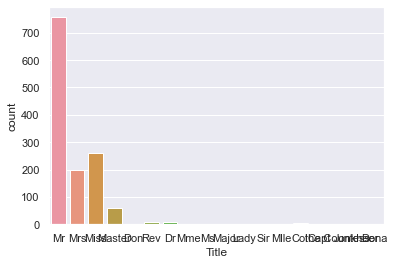

In [27]:
sns.set_theme(style="darkgrid")
sns.countplot(x="Title",data=train)

#### გამოვყოთ Master სხვა ძირითადი წოდებებისგან

In [28]:
train["Title"] = train["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train["Title"] = train["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
train["Title"] = train["Title"].astype(int)

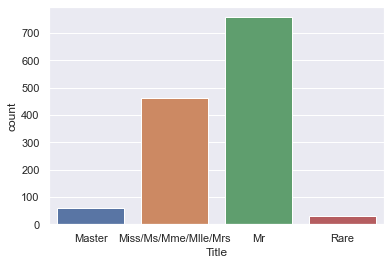

In [29]:
g = sns.countplot(x="Title", data=train)
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])


<AxesSubplot:xlabel='Family size', ylabel='Survived'>

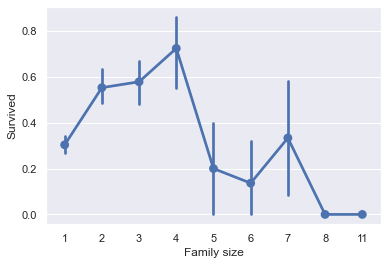

In [30]:
sns.pointplot(x="Family size",y="Survived",data = train)

#### ოჯახის წევრთა რაოდენობა დიდ როლს თამაშობს გადარჩენაში. ამიტომ შეგვიძლია ამისთვის ქვეკატეგორიები შევქმნათ

In [31]:
train['Single'] = train['Family size'].map(lambda s: 1 if s == 1 else 0)
train['SmallF'] = train['Family size'].map(lambda s: 1 if  s == 2  else 0)
train['MedF'] = train['Family size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
train['LargeF'] = train['Family size'].map(lambda s: 1 if s >= 5 else 0)

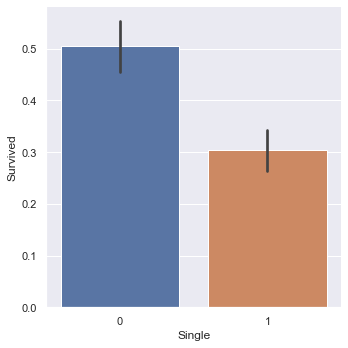

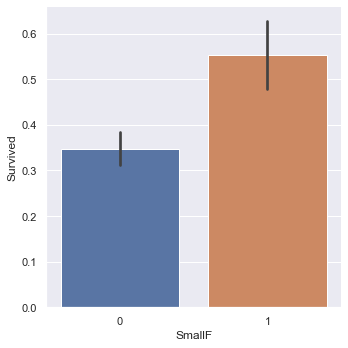

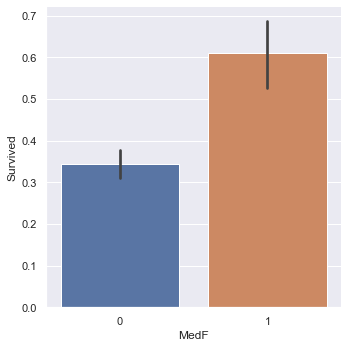

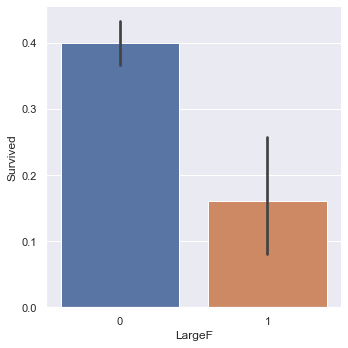

In [32]:
sns.catplot(x="Single",y="Survived",data=train,kind="bar")
sns.catplot(x="SmallF",y="Survived",data=train,kind="bar")
sns.catplot(x="MedF",y="Survived",data=train,kind="bar")
sns.catplot(x="LargeF",y="Survived",data=train,kind="bar")

In [33]:
train = pd.get_dummies(train, columns = ["Title"])
train = pd.get_dummies(train, columns = ["Embarked"], prefix="Em")

In [34]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Family size', 'Single', 'SmallF', 'MedF', 'LargeF', 'Title_0',
       'Title_1', 'Title_2', 'Title_3', 'Em_0', 'Em_1', 'Em_2'],
      dtype='object')

#### Modeling

In [35]:
train = train.drop(columns = 'Name',axis = 1)

In [36]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family size,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_0,Em_1,Em_2
0,0.0,3,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,1,0,0
1,1.0,1,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,0,1,0
2,1.0,3,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,1,0,0
3,1.0,1,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,1,0,0
4,0.0,3,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,1,0,0


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    float64
 1   Pclass       1309 non-null   int64  
 2   Sex          1309 non-null   int64  
 3   Age          1309 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Fare         1309 non-null   float64
 7   Family size  1309 non-null   int64  
 8   Single       1309 non-null   int64  
 9   SmallF       1309 non-null   int64  
 10  MedF         1309 non-null   int64  
 11  LargeF       1309 non-null   int64  
 12  Title_0      1309 non-null   uint8  
 13  Title_1      1309 non-null   uint8  
 14  Title_2      1309 non-null   uint8  
 15  Title_3      1309 non-null   uint8  
 16  Em_0         1309 non-null   uint8  
 17  Em_1         1309 non-null   uint8  
 18  Em_2         1309 non-null   uint8  
dtypes: flo

In [38]:
train['Survived'] = train['Survived'].fillna(0)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     1309 non-null   float64
 1   Pclass       1309 non-null   int64  
 2   Sex          1309 non-null   int64  
 3   Age          1309 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Fare         1309 non-null   float64
 7   Family size  1309 non-null   int64  
 8   Single       1309 non-null   int64  
 9   SmallF       1309 non-null   int64  
 10  MedF         1309 non-null   int64  
 11  LargeF       1309 non-null   int64  
 12  Title_0      1309 non-null   uint8  
 13  Title_1      1309 non-null   uint8  
 14  Title_2      1309 non-null   uint8  
 15  Title_3      1309 non-null   uint8  
 16  Em_0         1309 non-null   uint8  
 17  Em_1         1309 non-null   uint8  
 18  Em_2         1309 non-null   uint8  
dtypes: flo

In [40]:
# train = pd.read_csv('titanic_train_data.csv', sep = ';')
# test = pd.read_csv('titanic_test_data.csv', sep = ';')

In [41]:
# train.info()
# print("_"*40)
# test.info()

In [42]:
train.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family size,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_0,Em_1,Em_2
1304,0.0,3,0,29.881138,0,0,2.085672,1,1,0,0,0,0,0,1,0,1,0,0
1305,0.0,1,1,39.000000,0,0,4.690430,1,1,0,0,0,0,0,0,1,0,1,0
1306,0.0,3,0,38.500000,0,0,1.981001,1,1,0,0,0,0,0,1,0,1,0,0
1307,0.0,3,0,29.881138,0,0,2.085672,1,1,0,0,0,0,0,1,0,1,0,0
1308,0.0,3,0,29.881138,1,1,3.107198,3,0,0,1,0,1,0,0,0,0,1,0


In [43]:
leng = len(train_data)
trains = train.iloc[:leng,:]
print(trains.head())
tests = train.iloc[leng:,:]
print(tests.head())

   Survived  Pclass  Sex   Age  SibSp  Parch      Fare  Family size  Single  \
0       0.0       3    0  22.0      1      0  1.981001            2       0   
1       1.0       1    1  38.0      1      0  4.266662            2       0   
2       1.0       3    1  26.0      0      0  2.070022            1       1   
3       1.0       1    1  35.0      1      0  3.972177            2       0   
4       0.0       3    0  35.0      0      0  2.085672            1       1   

   SmallF  MedF  LargeF  Title_0  Title_1  Title_2  Title_3  Em_0  Em_1  Em_2  
0       1     0       0        0        0        1        0     1     0     0  
1       1     0       0        0        1        0        0     0     1     0  
2       0     0       0        0        1        0        0     1     0     0  
3       1     0       0        0        1        0        0     1     0     0  
4       0     0       0        0        0        1        0     1     0     0  
     Survived  Pclass  Sex   Age  SibSp  Parc

In [44]:
tests.drop(labels=["Survived"],axis = 1,inplace=True)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [45]:
# leng = len(train_data)
# train = train.iloc[:leng,:]
# print(train.head())
# test = train.iloc[leng:,:]
# print(test.head())

#tests.drop(labels=["Survived"],axis = 1,inplace=True)

In [46]:
tests.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Family size,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_0,Em_1,Em_2
891,3,0,34.5,0,0,2.057860,1,1,0,0,0,0,0,1,0,0,0,1
892,3,1,47.0,1,0,1.945910,2,0,1,0,0,0,1,0,0,1,0,0
893,2,0,62.0,0,0,2.270836,1,1,0,0,0,0,0,1,0,0,0,1
894,3,0,27.0,0,0,2.159003,1,1,0,0,0,0,0,1,0,1,0,0
895,3,1,22.0,1,1,2.508582,3,0,0,1,0,0,1,0,0,1,0,0


In [47]:
trains["Survived"] = trains["Survived"].astype(int)

y_train = trains["Survived"]

X_train = trains.drop(labels = ["Survived"],axis = 1)

X_test = tests



C:\Users\nikan\AppData\Local\Temp/ipykernel_9968/3393951736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trains["Survived"] = trains["Survived"].astype(int)


In [48]:
#### აქ ამ პრობლემას ვაწყდები და გამოსარკვევია რატომ
X_test.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Family size,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_0,Em_1,Em_2
1304,3,0,29.881138,0,0,2.085672,1,1,0,0,0,0,0,1,0,1,0,0
1305,1,1,39.000000,0,0,4.690430,1,1,0,0,0,0,0,0,1,0,1,0
1306,3,0,38.500000,0,0,1.981001,1,1,0,0,0,0,0,1,0,1,0,0
1307,3,0,29.881138,0,0,2.085672,1,1,0,0,0,0,0,1,0,1,0,0
1308,3,0,29.881138,1,1,3.107198,3,0,0,1,0,1,0,0,0,0,1,0


In [49]:
log_reg = LogisticRegression(random_state = 2)

In [50]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_pred

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,